# Objective
* 20181226: 
    * Predict stock price in next day using linear regression
    * Given prices for the last N days, we train a model, and predict for day N+1

In [20]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import pandas as pd

%matplotlib inline

#### Input params ##################
stk_path = "./coding_work_competition/amzn_data.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 20                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [21]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    print (N)
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [22]:
df = pd.read_csv(stk_path, sep = ",")
df = df[df['label']=="3:59 PM"]
# Convert Date column to datetime
df.loc[:, 'date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,unnamed:_0,unnamed:_0.1,date,minute,label,high,low,open,close,average,...,notional,numberoftrades,symbol,year,month,day,hour,min,min1,stamp
12479,389,389,2020-05-26,15:59,3:59 PM,2423.235,2421.010,2421.960,2423.155,2422.437,...,2102675.315,29,AMZN,2020,5,26,15,59,59,2020-05-26 15:59:00
12089,389,389,2020-05-27,15:59,3:59 PM,2410.710,2409.050,2409.990,2409.745,2410.160,...,1253283.320,17,AMZN,2020,5,27,15,59,59,2020-05-27 15:59:00
11699,389,389,2020-05-28,15:59,3:59 PM,2403.220,2399.310,2399.610,2400.060,2401.145,...,4602995.210,35,AMZN,2020,5,28,15,59,59,2020-05-28 15:59:00
11309,389,389,2020-05-29,15:59,3:59 PM,2439.710,2436.010,2436.170,2437.430,2437.858,...,4534416.785,50,AMZN,2020,5,29,15,59,59,2020-05-29 15:59:00
10919,389,389,2020-06-01,15:59,3:59 PM,2474.300,2471.280,2474.220,2471.280,2473.909,...,1892540.600,19,AMZN,2020,6,1,15,59,59,2020-06-01 15:59:00
10529,389,389,2020-06-02,15:59,3:59 PM,2472.690,2471.720,2471.720,2472.580,2471.911,...,1188989.190,6,AMZN,2020,6,2,15,59,59,2020-06-02 15:59:00
10139,389,389,2020-06-03,15:59,3:59 PM,2478.270,2476.710,2477.515,2477.520,2477.512,...,2509719.240,19,AMZN,2020,6,3,15,59,59,2020-06-03 15:59:00
9749,389,389,2020-06-04,15:59,3:59 PM,2460.570,2459.485,2459.485,2460.190,2460.001,...,1030740.525,19,AMZN,2020,6,4,15,59,59,2020-06-04 15:59:00
9359,389,389,2020-06-05,15:59,3:59 PM,2482.000,2480.120,2480.120,2481.990,2481.015,...,2337116.270,36,AMZN,2020,6,5,15,59,59,2020-06-05 15:59:00
8969,389,389,2020-06-08,15:59,3:59 PM,2525.020,2522.905,2522.930,2525.020,2523.337,...,2094369.970,37,AMZN,2020,6,8,15,59,59,2020-06-08 15:59:00


Text(0, 0.5, 'USD')

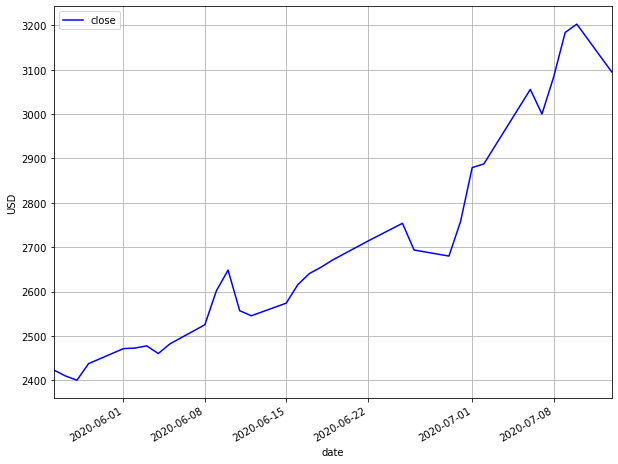

In [23]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test set

In [24]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 20
num_cv = 6
num_test = 6
train.shape = (20, 21)
cv.shape = (6, 21)
train_cv.shape = (26, 21)
test.shape = (6, 21)


# EDA

Text(0, 0.5, 'USD')

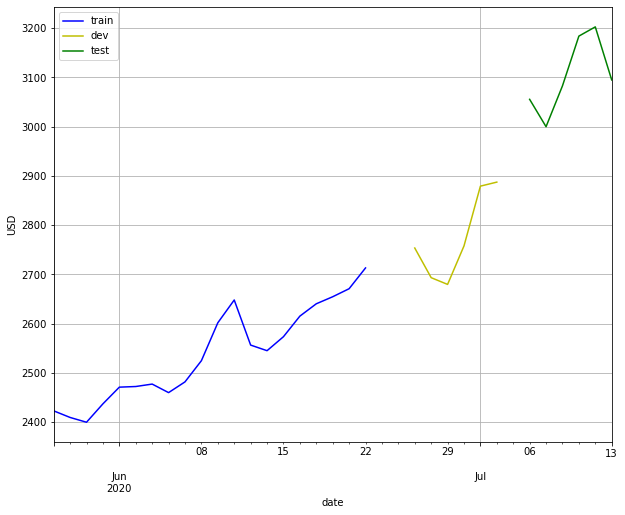

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Linear Regression

In [26]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    R2.append(r2_score(cv['close'], est_list))
    mape.append(get_mape(cv['close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
RMSE = [66.27252541589156, 76.82503774811947, 85.77518241072173, 86.64966675017675, 81.64765558330478, 76.71684769464704, 74.58464343032854, 74.95944773442704, 75.87284596459956, 70.76116272951799, 62.351432668540596, 60.30765475892432, 66.78144763300506, 73.2076802941498, 74.34027493459193, 72.14560023402372, 69.22173854726938, 67.6561763717835, 68.41325102910768, 70.0254856713266]
R2 = [0.34104512055662195, 0.1144885072483095, -0.10385476854343545, -0.12647726498741418, -0.00017518559274232182, 0.11698082173713564, 0.16538252593916747, 0.15697317523498522, 0.13630304853738784, 0.24876025169279992, 0.4167140556803598, 0.4543256780871766, 0.3308857244067245, 0.1959150584775491, 0.17084263382064035, 0.21907677440272455, 0.28109145975100025, 0.31324230081094007, 0.2977866284276067, 0.2642997617032258]
MAPE = [1.9242628670454023, 2.381345926068493, 2.6855016934776472, 2.634777947461841, 2.524589904137975, 2.4023856668281316, 2.33002328591

,unnamed:_0,unnamed:_0.1,date,minute,label,high,low,open,close,average,...,est_N11,est_N12,est_N13,est_N14,est_N15,est_N16,est_N17,est_N18,est_N19,est_N20
4679,389,389,2020-06-25,15:59,3:59 PM,2754.72,2751.025,2752.710,2753.760,2753.152,...,2693.795909,2702.264167,2708.765192,2708.272912,2706.368238,2703.138125,2702.921801,2705.169118,2704.152719,2700.443737
4289,389,389,2020-06-26,15:59,3:59 PM,2695.74,2692.845,2694.510,2693.545,2694.036,...,2724.007455,2727.200303,2733.479615,2738.384505,2737.068000,2734.524250,2730.787206,2729.921176,2731.455614,2729.978553
3899,389,389,2020-06-29,15:59,3:59 PM,2679.88,2677.470,2679.050,2679.880,2678.113,...,2738.034091,2728.839167,2732.567500,2739.137967,2744.476524,2743.989625,2742.235551,2739.241797,2738.856930,2740.697553
3509,389,389,2020-06-30,15:59,3:59 PM,2762.45,2757.440,2760.610,2758.010,2759.473,...,2753.030818,2734.585530,2727.589038,2732.127088,2739.263095,2745.255625,2745.747316,2744.928725,2742.821842,2743.081079
3119,389,389,2020-07-01,15:59,3:59 PM,2879.39,2874.535,2875.475,2879.390,2877.265,...,2773.076545,2772.646591,2755.492500,2748.480934,2752.137000,2758.395625,2763.759963,2764.057614,2763.138684,2760.999447


(2, 30)

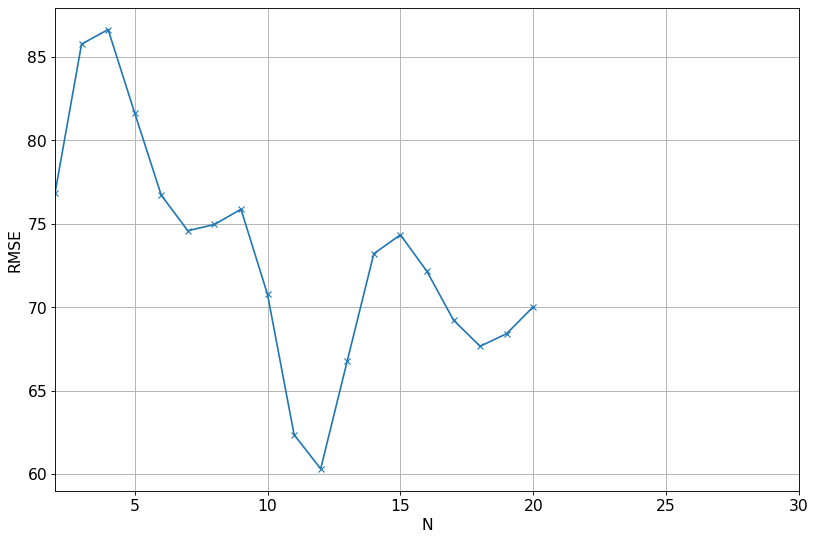

In [27]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Lowest RMSE is achieved with N=1, followed by N=5

Text(0, 0.5, 'R2')

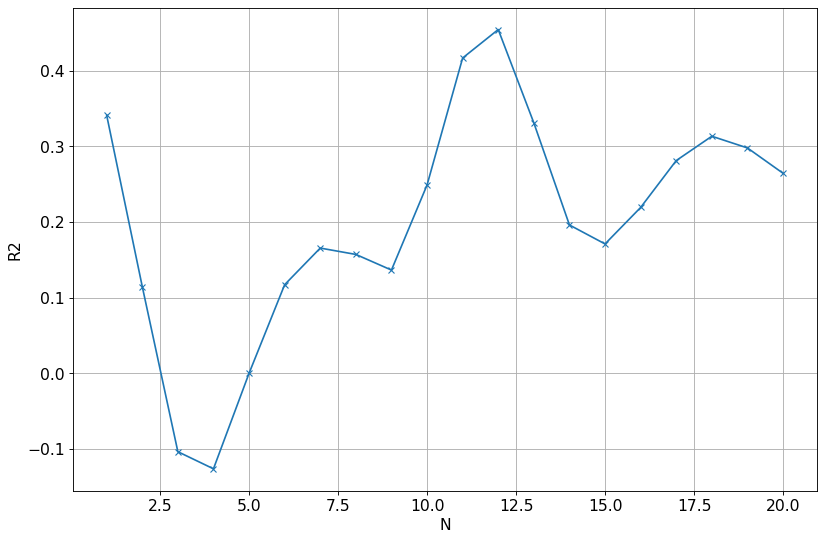

In [28]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

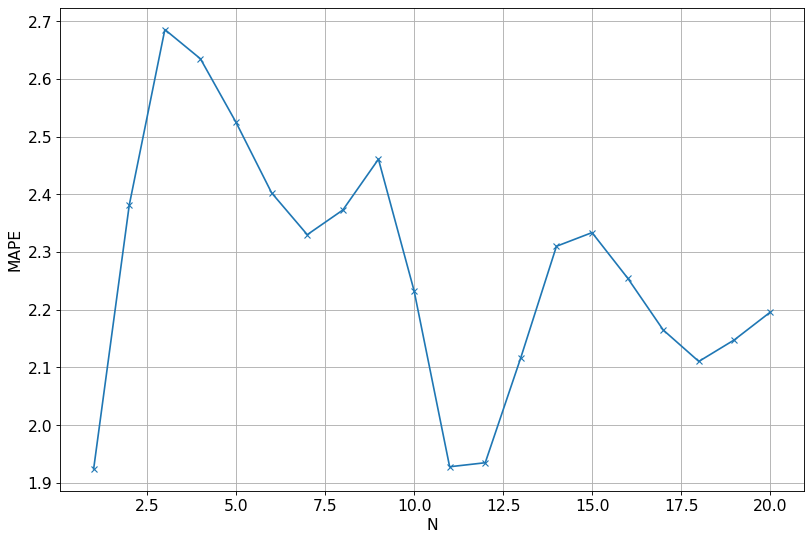

In [29]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [30]:
# Set optimum N
N_opt = 5

# Plot predictions for a specific day. For checking

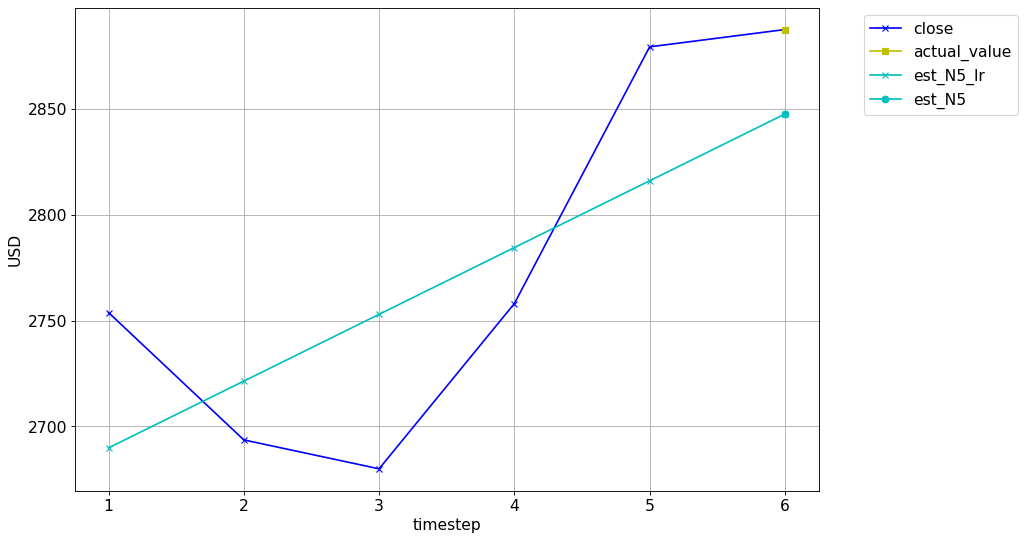

In [43]:
# Specify the day you are interested in
day = pd.Timestamp(date(2020, 8, 11))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['close'], 'ys-')
legend_list = ['close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# Plot predictions on dev set

Text(0, 0.5, 'USD')

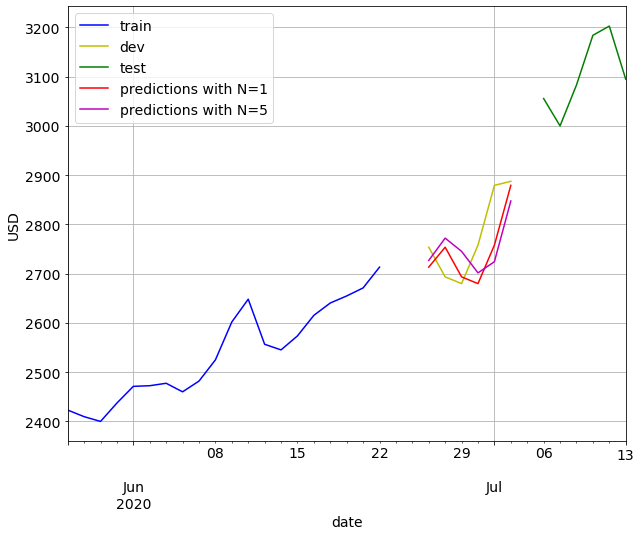

In [44]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

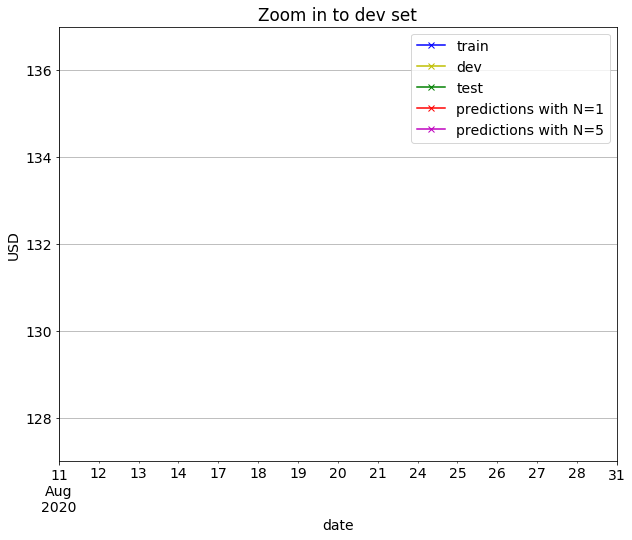

In [45]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 8, 11), date(2020, 8, 30)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

# Final model

In [46]:
est_list = get_preds_lin_reg(df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("R2 = %0.3f" % r2_score(test['close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['close'], est_list))
test.head()

5
RMSE = 92.072
R2 = -0.706
MAPE = 2.564%


,unnamed:_0,unnamed:_0.1,date,minute,label,high,low,open,close,average,...,numberoftrades,symbol,year,month,day,hour,min,min1,stamp,est_N5
2339,389,389,2020-07-06,15:59,3:59 PM,3058.08,3055.63,3058.05,3055.63,3057.039,...,29,AMZN,2020,7,6,15,59,59,2020-07-06 15:59:00,2955.947
1949,389,389,2020-07-07,15:59,3:59 PM,3003.97,3000.06,3002.85,3000.06,3001.674,...,46,AMZN,2020,7,7,15,59,59,2020-07-07 15:59:00,3116.414
1559,389,389,2020-07-08,15:59,3:59 PM,3082.98,3080.01,3082.35,3082.98,3081.634,...,31,AMZN,2020,7,8,15,59,59,2020-07-08 15:59:00,3114.234
1169,389,389,2020-07-09,15:59,3:59 PM,3185.72,3180.59,3181.25,3184.00,3183.506,...,51,AMZN,2020,7,9,15,59,59,2020-07-09 15:59:00,3137.027
779,389,389,2020-07-10,15:59,3:59 PM,3205.77,3202.72,3205.77,3202.72,3204.192,...,29,AMZN,2020,7,10,15,59,59,2020-07-10 15:59:00,3228.111


Text(0, 0.5, 'USD')

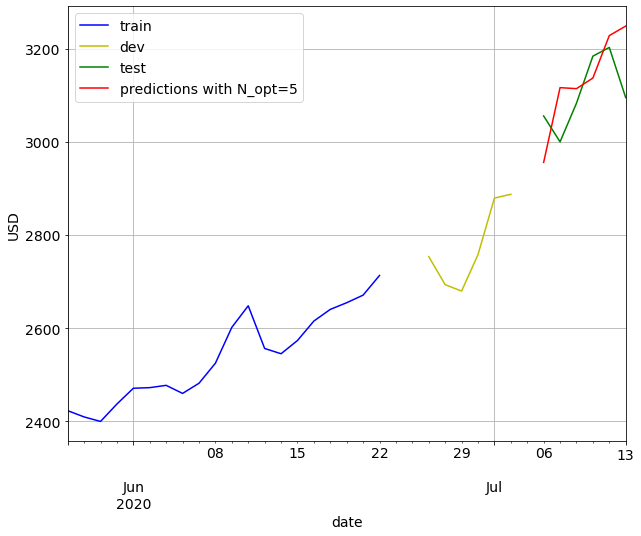

In [47]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

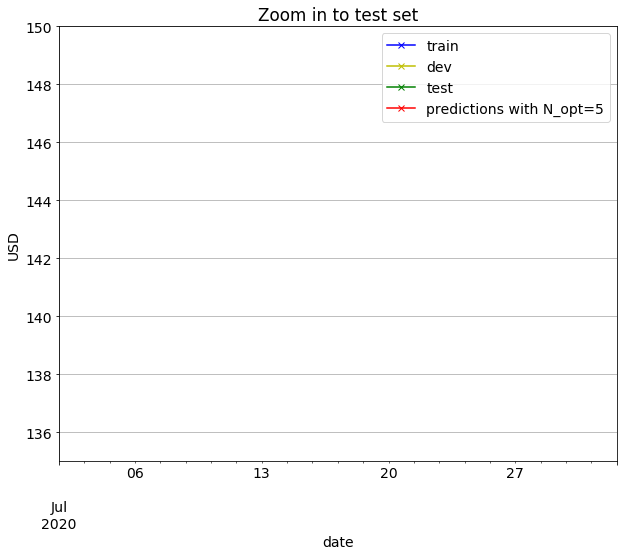

In [48]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='bx-', grid=True)
ax = cv.plot(x='date', y='close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 1), date(2020, 7, 31)])
ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

(130, 155)

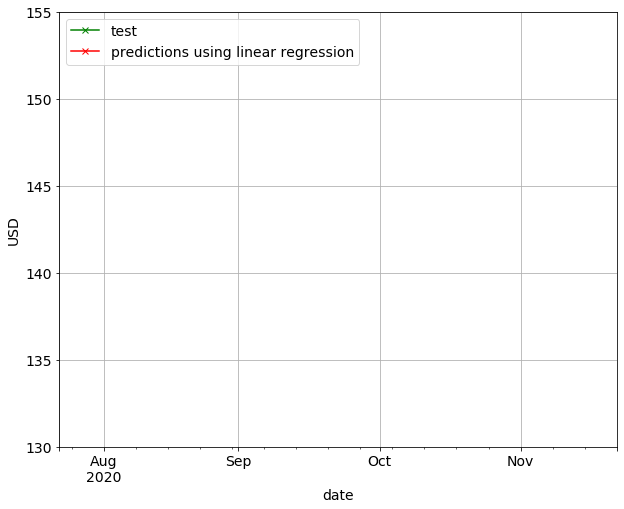

In [50]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 23), date(2020, 11, 23)])
ax.set_ylim([130, 155])

In [51]:
# Save as csv
test_lin_reg = test
test_lin_reg.to_csv("./out/amz.csv")

FileNotFoundError: [Errno 2] No such file or directory: './out/amz.csv'

# Findings
* On the dev set, the lowest RMSE is 1.2 which is achieved using N=1, ie. using value on day t-1 to predict value on day t
* On the dev set, the next lowest RMSE is 1.36 which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t
* We will use N_opt=5 in this work since our aim here is to use linear regression
* On the test set, the RMSE is 1.42 and MAPE is 0.707% using N_opt=5